Copyright (C) 2022 Rodrigo Becerril Ferreyra

This program is free software; you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation; either version 2 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License along
with this program; if not, see <http://www.gnu.org/licenses/old-licenses/gpl-2.0.en.html>.

## Setup

In [98]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import os
from math import sqrt
import tarfile # for extracting the images archive

## Image Preprocessing

In [100]:
target_size = (128, 128)

In [102]:
# Extract images over old images.
with tarfile.open("archive.tar", 'r') as tarchive:
    tarchive.extractall()

In [101]:
# Resize all images to be target_size.
# First, resize so that the shortest side is the same as target_size,
#   then crop with the center as the anchor.
for root, dirs, files in os.walk("raw-img"):
    for name in files:
        filename = os.path.join(root, name)
        with Image.open(filename) as im:
            size = im.size
            if size == target_size:
                continue

            longest = min(size)
            scale = target_size[0]/longest
            
            if size[0] < size[1]:
                resized_image = im.resize((target_size[0], int(size[1] * scale)), resample=Image.Resampling.BICUBIC)
            else:
                resized_image = im.resize((int(size[0] * scale), target_size[0]), resample=Image.Resampling.BICUBIC)

        x1 = (resized_image.size[0] - target_size[0]) // 2
        y1 = (resized_image.size[1] - target_size[1]) // 2
        x2 = x1 + target_size[0]
        y2 = y1 + target_size[1]
        cropped_image = resized_image.crop((x1, y1, x2, y2))

        cropped_image.save(filename)

## Import and prepare dataset

In [90]:
batch_size = 16
train_val_split = 0.2

ds = tf.keras.utils.image_dataset_from_directory(
    "raw-img",
    image_size=target_size,
    batch_size=batch_size)

class_names = ds.class_names
size = len(ds)
train_size, test_size = int(8/10 * size), int(2/10 * size)
while train_size + test_size < size:
    train_size += 1

train_ds = ds.take(train_size)
val_ds = train_ds.take(int(0.1 * len(train_ds)))
test_ds = ds.skip(train_size).take(test_size)

Found 26179 files belonging to 10 classes.


## Build model and train

In [91]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),
    # [128, 128, 3]
    tf.keras.layers.Conv2D(filters=16, kernel_size=2, strides=2, activation="relu"),
    # [64, 64, 16]
    tf.keras.layers.Conv2D(filters=32, kernel_size=4, strides=2, activation="relu"),
    # [31, 31, 32]
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu"),
    # [29, 29, 64]
    tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
    # [14, 14, 64]
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu"),
    # [12, 12, 64]
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, activation="relu"),
    # [10, 10, 64]
    tf.keras.layers.Flatten(),
    # 6400
    #tf.keras.layers.Dense(units=6400, activation="relu"),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(units=1024, activation="relu"),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

#cnn.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
cnn.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

cnn.build((None, target_size[0], target_size[1], 3))
cnn.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_19 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 conv2d_69 (Conv2D)          (None, 64, 64, 16)        208       
                                                                 
 conv2d_70 (Conv2D)          (None, 31, 31, 32)        8224      
                                                                 
 conv2d_71 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 12, 12, 64)        36928     
                                                     

In [92]:
history = cnn.fit(train_ds, epochs=30, validation_data=val_ds)

Epoch 1/30
1310/1310 [==============================] - 19s 14ms/step - loss: 2.1750 - accuracy: 0.2209 - val_loss: 2.0462 - val_accuracy: 0.2991
Epoch 2/30
1310/1310 [==============================] - 14s 11ms/step - loss: 1.9787 - accuracy: 0.3102 - val_loss: 1.8436 - val_accuracy: 0.3640
Epoch 3/30
1310/1310 [==============================] - 14s 11ms/step - loss: 1.8066 - accuracy: 0.3735 - val_loss: 1.6663 - val_accuracy: 0.4380
Epoch 4/30
1310/1310 [==============================] - 14s 11ms/step - loss: 1.6480 - accuracy: 0.4354 - val_loss: 1.5312 - val_accuracy: 0.4766
Epoch 5/30
1310/1310 [==============================] - 14s 11ms/step - loss: 1.5280 - accuracy: 0.4739 - val_loss: 1.3650 - val_accuracy: 0.5305
Epoch 6/30
1310/1310 [==============================] - 14s 11ms/step - loss: 1.4454 - accuracy: 0.5073 - val_loss: 1.3050 - val_accuracy: 0.5472
Epoch 7/30
1310/1310 [==============================] - 14s 11ms/step - loss: 1.3661 - accuracy: 0.5309 - val_loss: 1.2637 -

## Evaluate model

In [93]:
score = cnn.evaluate(test_ds)

327/327 [==============================] - 8s 11ms/step - loss: 1.8036 - accuracy: 0.6097


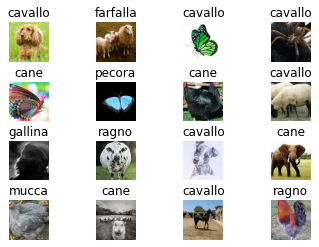

In [96]:
# Make a prediction from the first batch in the test dataset.
pred_ds = test_ds.take(1)
prediction = np.argmax(cnn.predict(pred_ds), axis=-1)
#actual = [label for _, label in pred_ds]

# Display prediction.
for images, labels in pred_ds:
    for i in range(batch_size):
        ax = plt.subplot(int(sqrt(batch_size)), int(sqrt(batch_size)), i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[prediction[i]])
        plt.axis("off")

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()